In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data=pd.read_csv("./data_paper/Swelling35C.csv")
data.head()

,Unnamed: 0,Cycle,max.,min.,max.-min.,CIV,CCVIS,CCVES,CVIS,CVES,DIV,DVSOC50,SOH
0,0,1,20.5,3.7,16.8,2.6737,16.526,1.938,0.02659,0.000275,2.6055,3.2598,1.000000
1,1,2,21.1,4.1,17.0,2.6749,16.502,1.978,0.03442,0.000455,2.6050,3.2598,1.000970
2,2,3,21.2,4.3,16.9,2.6802,16.396,1.982,0.03404,0.000475,2.6043,3.2596,1.001109
3,3,4,21.4,4.6,16.8,2.6830,16.340,1.978,0.03331,0.000409,2.6049,3.2598,1.001111
4,4,5,21.7,4.8,16.9,2.6845,16.310,1.892,0.03467,0.000400,2.6033,3.2593,1.000972


In [3]:
print(data['Cycle'].max())

207


In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
def bisquare(x):
    x=abs(x)
    res=[]
    for v in x:
        if v<1:
            res.append((1-v**2)**2)
        else:
            res.append(0)
    return np.array(res)

def tricube(x):
    x=abs(x)
    res=[]
    for v in x:
        if v<1:
            res.append((1-v**3)**3)
        else:
            res.append(0)
    return np.array(res)

def get_n_th_distance(x,y,n):
    y=np.array(y)
    distance=abs(y-x)
    distance=np.sort(distance)
    return distance[n-1]


(207,)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            WLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     674.6
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           1.19e-90
Time:                        20:58:22   Log-Likelihood:                   -inf
No. Observations:                 207   AIC:                               inf
Df Residuals:                     204   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.2245      4.902      2.902  

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


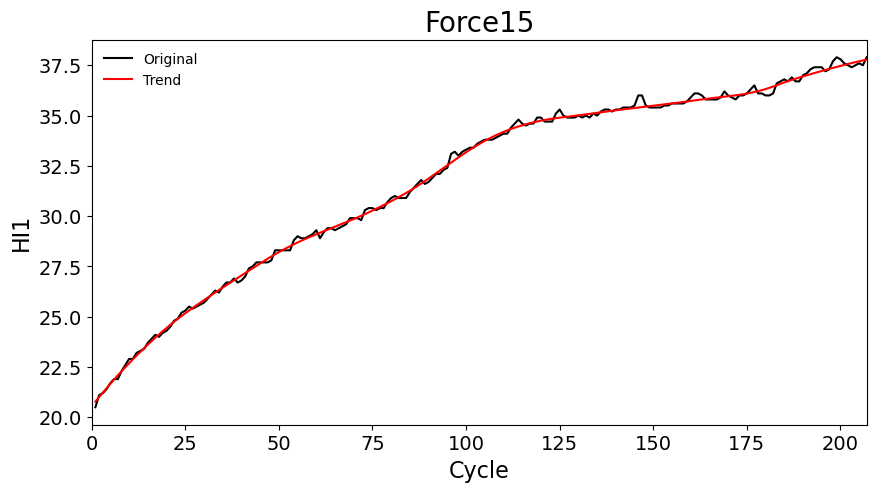

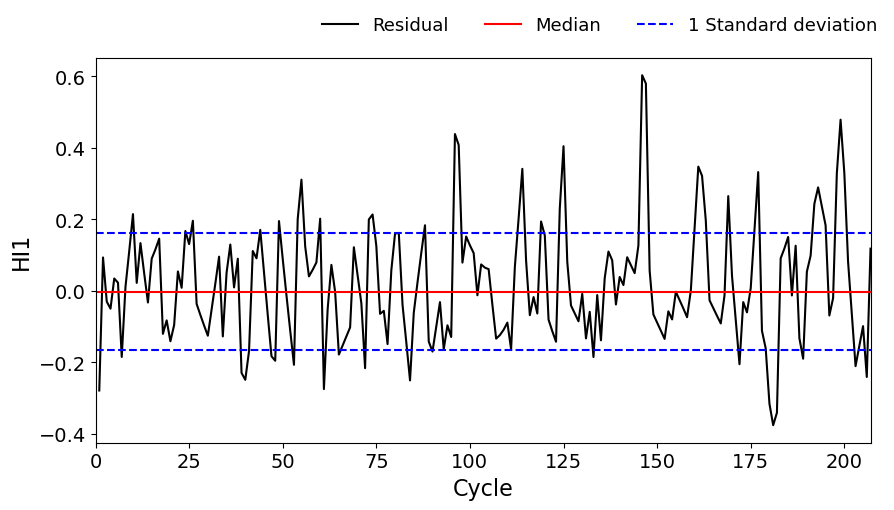

1
7
10
24
26
39
40
41
44
47
48
49
53
54
55
60
61
65
72
73
74
81
84
88
90
96
97
113
114
119
124
125
133
146
147
160
161
162
163
169
172
176
177
180
181
182
189
192
193
194
195
198
199
200
203
206


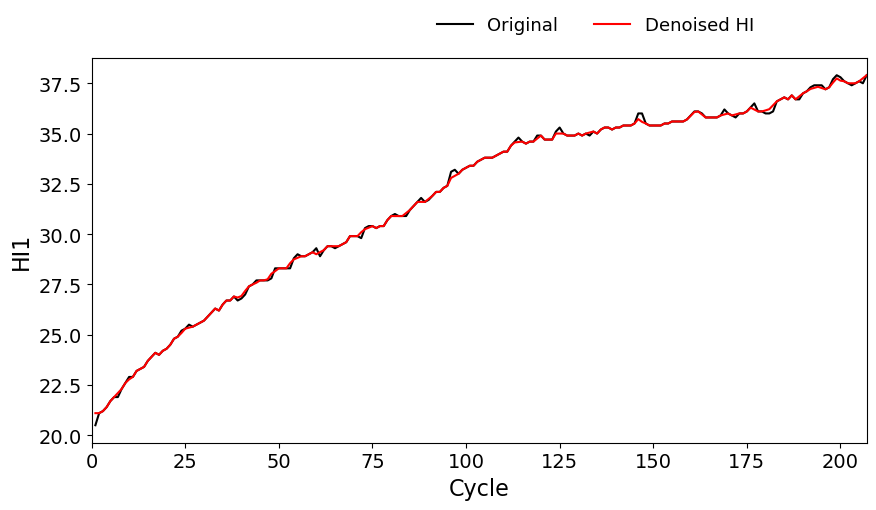

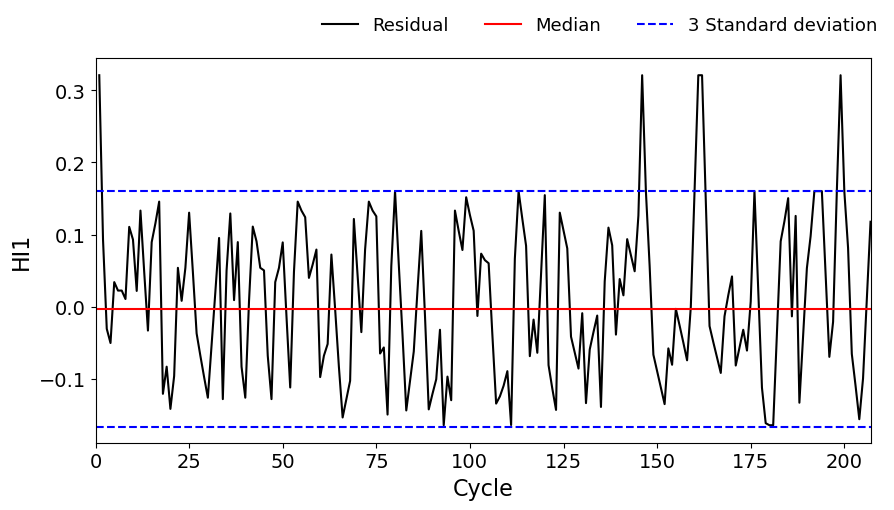

outlier
outlier
outlier
outlier
outlier
outlier
outlier
outlier
outlier


In [29]:
##############################################################
##############################################################

x= data['Cycle']
y= data['max.']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['max.']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI1",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI1",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    #t=y_res[cycle-1]
    
    if median+(-1)*std<=t<=median+1*std:
        denoised_val=data.loc[data['Cycle']==cycle,'max.'].iloc[0]
    else :
        print(cycle)
        if cycle==1:
            denoised_val=data.loc[data['Cycle']==cycle+1,'max.'].iloc[0]
        elif cycle==len(y_res):
            denoised_val=data.loc[data['Cycle']==cycle-1,'max.'].iloc[0]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=np.median([denoised_1,denoised_2])
            abs_diff=np.abs(minus-target)
            min_index=np.argmin(abs_diff)
            
            denoised_val=y_trend[cycle-1]+minus[min_index] # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_max=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_max,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI1",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

#########

plt.figure(figsize=(10,5))
plt.plot(x, y_denoised_max-y_trend,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI1",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='3 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


y_res_2=y_denoised_max-y_trend
for t in y_res_2:
    if t>(1*std) or t<-(1*std):
        print("outlier")
    else:
        pass




(207,)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.889
Model:                            WLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     816.4
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           4.47e-98
Time:                        20:58:23   Log-Likelihood:                   -inf
No. Observations:                 207   AIC:                               inf
Df Residuals:                     204   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.3651      4.736     -2.189  

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


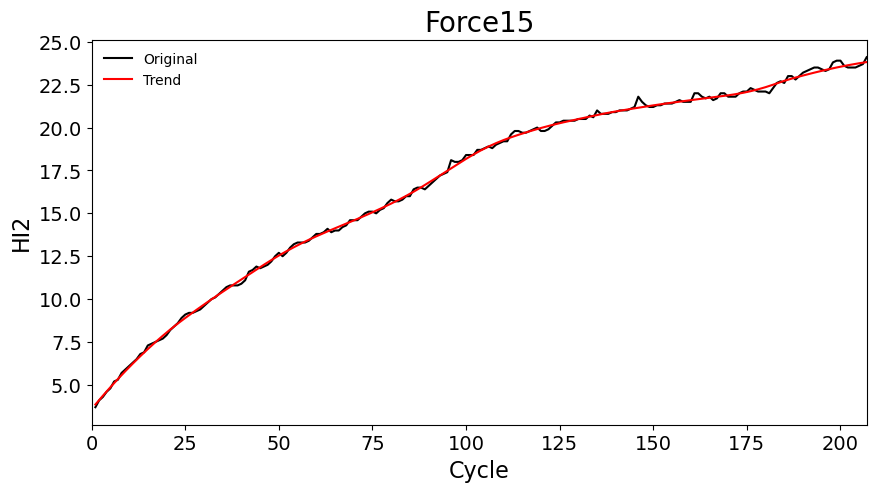

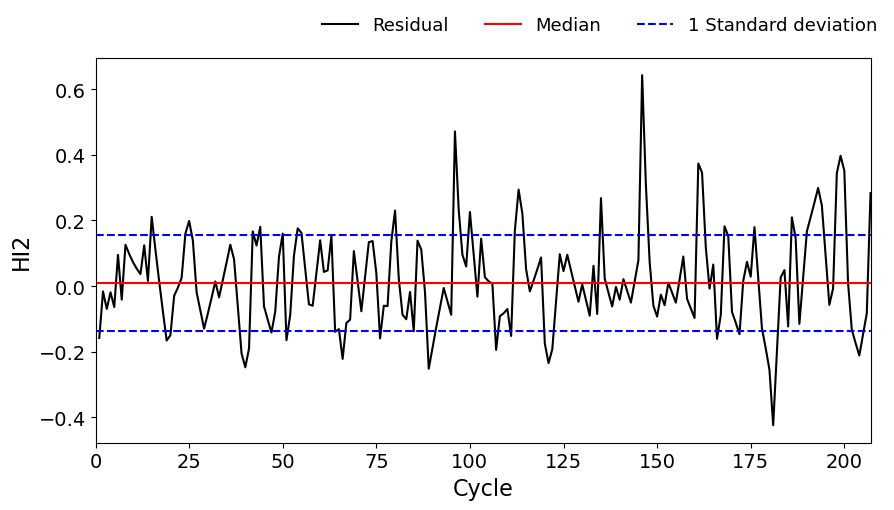

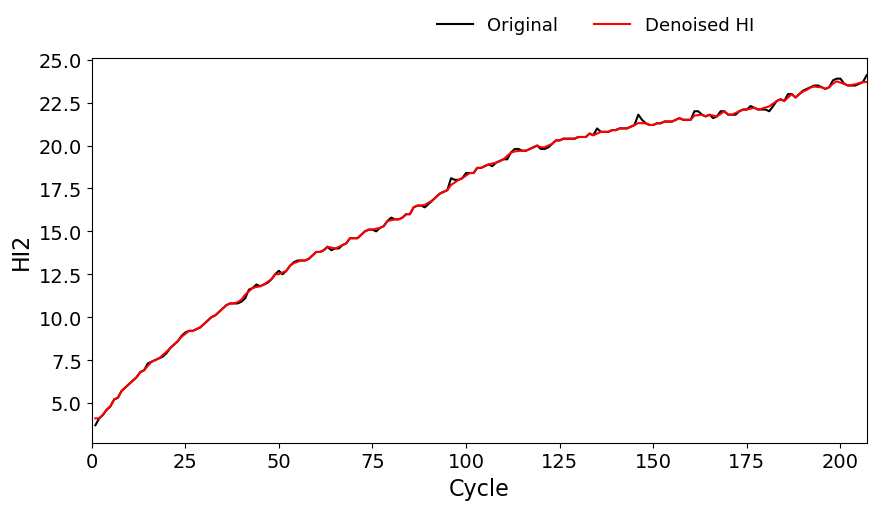

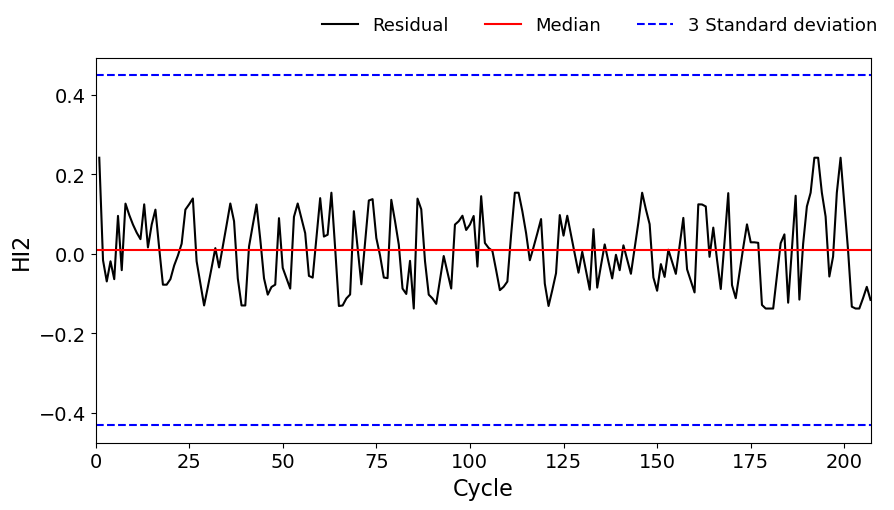

In [30]:
x= data['Cycle']
y= data['min.']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['min.']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI2",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI2",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-1)*std<=t<=median+1*std:
        denoised_val=data.loc[data['Cycle']==cycle,'min.'].iloc[0]
    else :
        if cycle==1:
            denoised_val=data.loc[data['Cycle']==cycle+1,'min.'].iloc[0]
        elif cycle==len(y_res):
            denoised_val=data.loc[data['Cycle']==cycle-1,'min.'].iloc[0]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            
            
            target=np.median([denoised_1,denoised_2])
            abs_diff=np.abs(minus-target)
            min_index=np.argmin(abs_diff)
            
            denoised_val=y_trend[cycle-1]+minus[min_index] # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_min=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_min,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI2",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

#########

plt.figure(figsize=(10,5))
plt.plot(x, y_denoised_min-y_trend,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI2",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+3*std,color='blue',linestyle='--',label='3 Standard deviation')
plt.axhline(median-3*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


y_res_2=y_denoised_min-y_trend
for t in y_res_2:
    if t>(3*std) or t<-(3*std):
        print("outlier")
    else:
        pass



(207,)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.157
Model:                            WLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     19.04
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           2.61e-08
Time:                        21:00:24   Log-Likelihood:                   -inf
No. Observations:                 207   AIC:                               inf
Df Residuals:                     204   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.5895      2.348     10.473  

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


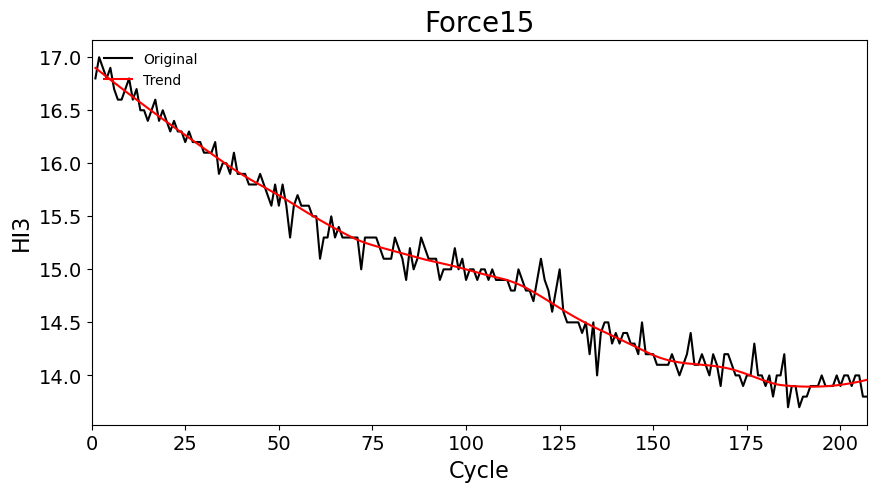

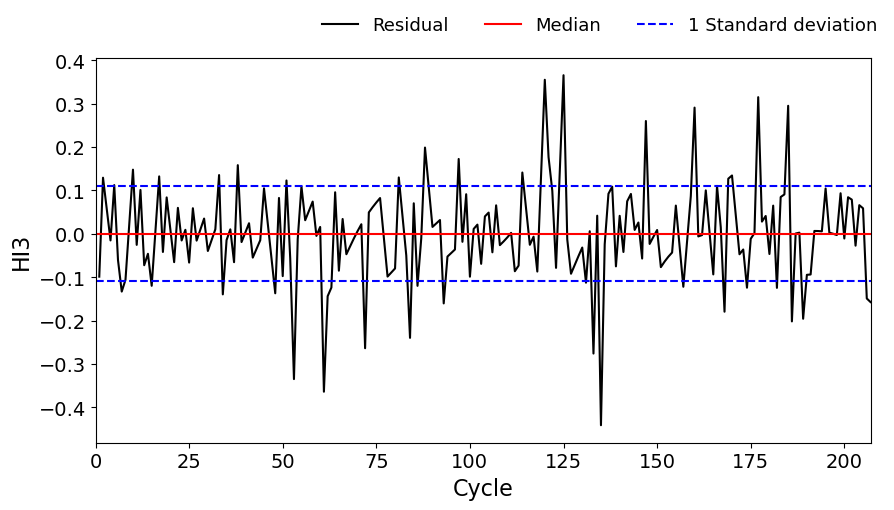

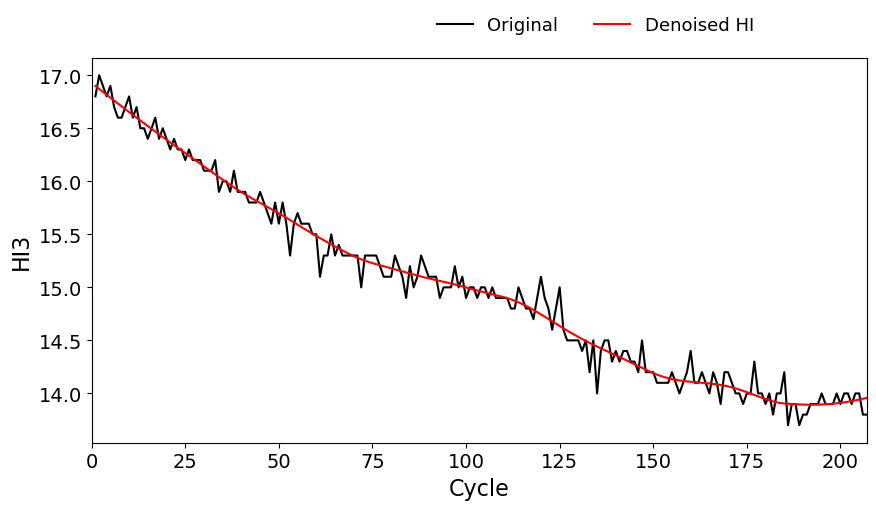

In [58]:
x= data['Cycle']
y= data['max.-min.']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['max.-min.']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI3",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI3",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-1)*std<=t<=median+1*std:
        denoised_val=data.loc[data['Cycle']==cycle,'max.-min.'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
           
            
            target=np.median([denoised_1,denoised_2])
            abs_diff=np.abs(minus-target)
            min_index=np.argmin(abs_diff)
            
            denoised_val=y_trend[cycle-1]+minus[min_index] # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_maxmin=np.array(denoised)
y_denoised_maxmin=y_trend


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_maxmin,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI3",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(207,)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.797
Model:                            WLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     400.7
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           2.20e-71
Time:                        21:00:39   Log-Likelihood:                   -inf
No. Observations:                 207   AIC:                               inf
Df Residuals:                     204   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5967      0.233     11.164  

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


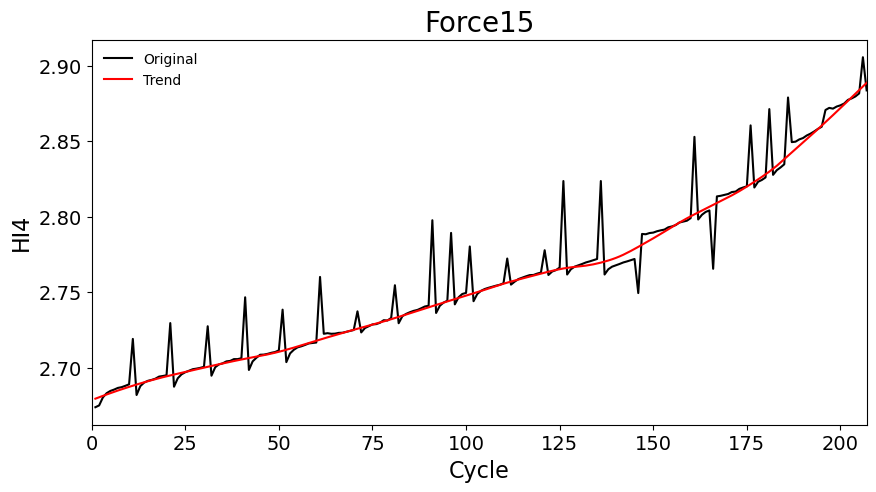

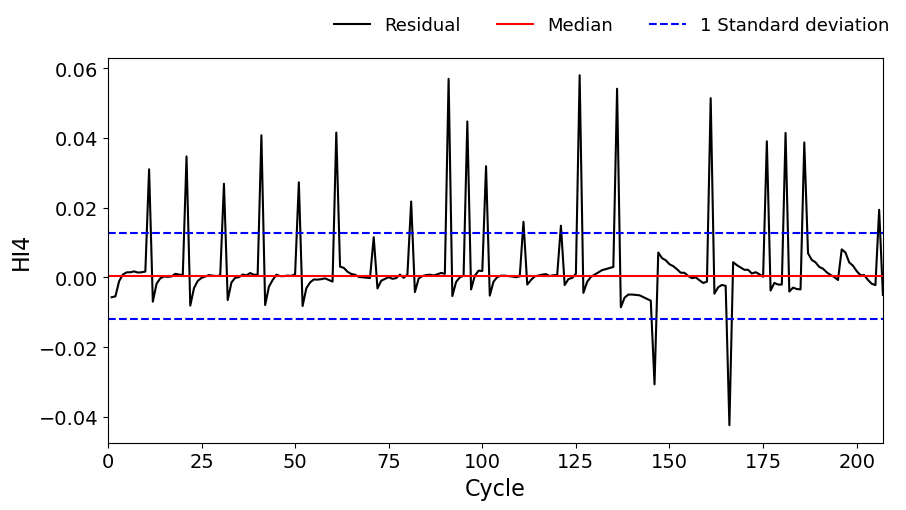

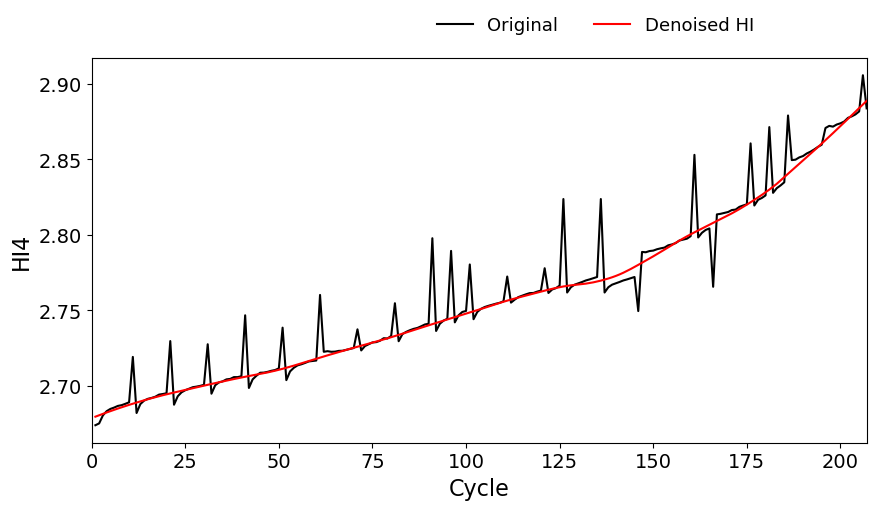

In [59]:
x= data['Cycle']
y= data['CIV']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['CIV']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI4",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI4",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-1)*std<=t<=median+1*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CIV'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            target=np.median([denoised_1,denoised_2])
            abs_diff=np.abs(minus-target)
            min_index=np.argmin(abs_diff)
            
            denoised_val=y_trend[cycle-1]+minus[min_index] # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_civ=np.array(denoised)
y_denoised_civ=y_trend


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_civ,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI4",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(207,)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.797
Model:                            WLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     400.6
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           2.25e-71
Time:                        20:58:26   Log-Likelihood:                   -inf
No. Observations:                 207   AIC:                               inf
Df Residuals:                     204   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.1269      4.645      3.903  

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


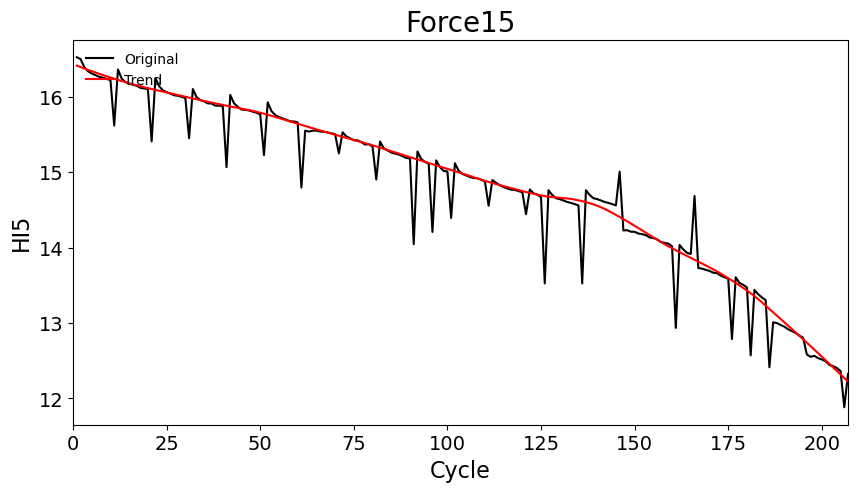

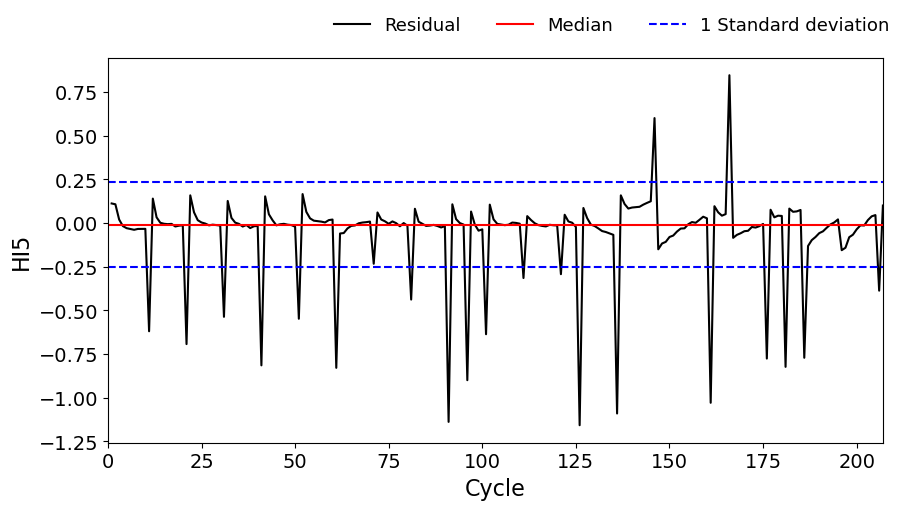

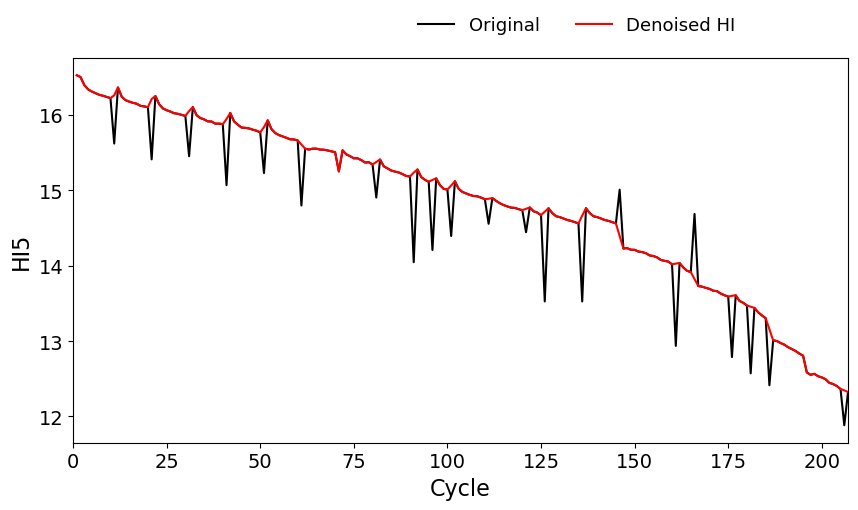

In [33]:
x= data['Cycle']
y= data['CCVIS']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['CCVIS']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI5",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI5",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-1)*std<=t<=median+1*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CCVIS'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            target=np.median([denoised_1,denoised_2])
            abs_diff=np.abs(minus-target)
            min_index=np.argmin(abs_diff)
            
            denoised_val=y_trend[cycle-1]+minus[min_index] # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_CCVIS=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_CCVIS,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI5",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(207,)
(207,)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.418
Model:                            WLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     73.16
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           1.11e-24
Time:                        20:58:27   Log-Likelihood:                   -inf
No. Observations:                 207   AIC:                               inf
Df Residuals:                     204   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9104      0.517      

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


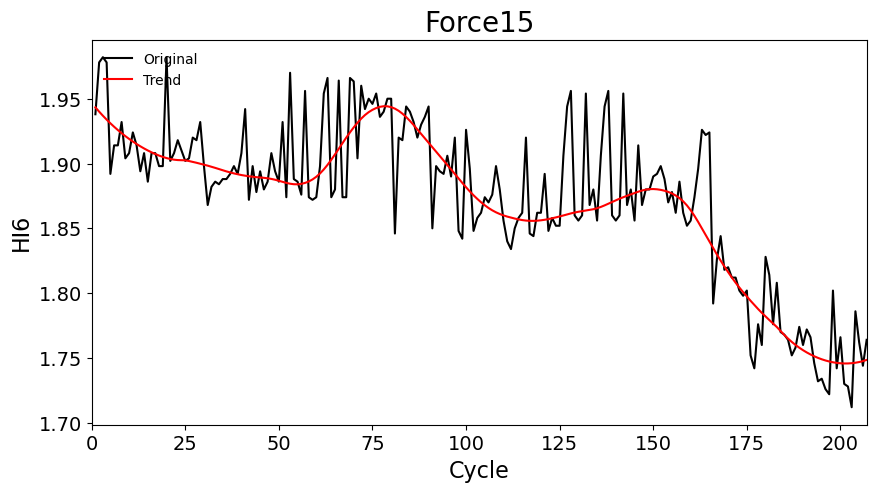

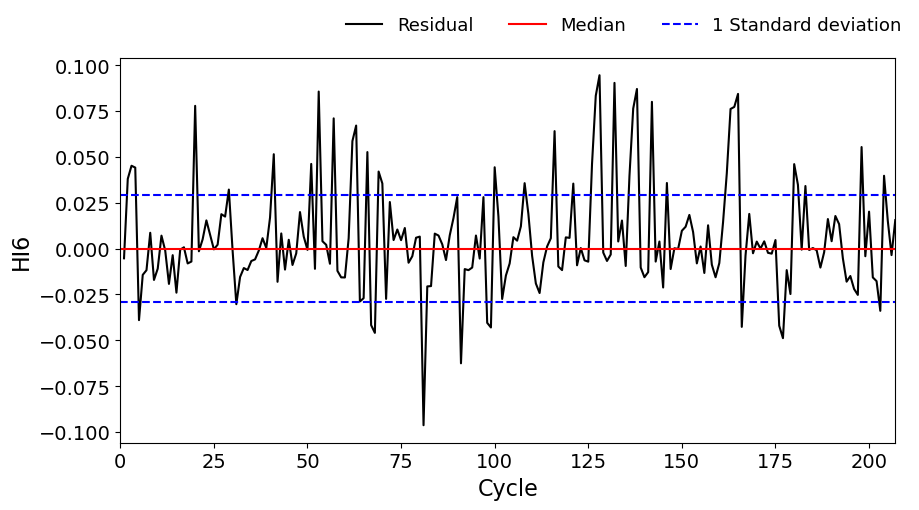

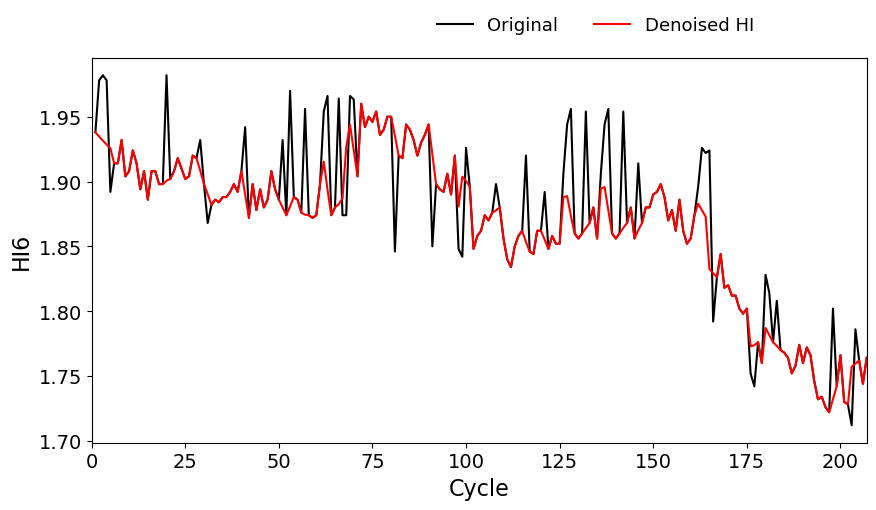

In [34]:
x= data['Cycle']
y= data['CCVES']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)
print(y.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['CCVES']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI6",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI6",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-1)*std<=t<=median+1*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CCVES'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            target=np.median([denoised_1,denoised_2])
            abs_diff=np.abs(minus-target)
            min_index=np.argmin(abs_diff)
            
            denoised_val=y_trend[cycle-1]+minus[min_index] # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_CCVES=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_CCVES,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI6",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(207,)
(207,)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            WLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     12.06
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           1.12e-05
Time:                        20:58:27   Log-Likelihood:                   -inf
No. Observations:                 207   AIC:                               inf
Df Residuals:                     204   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1260      0.045      

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


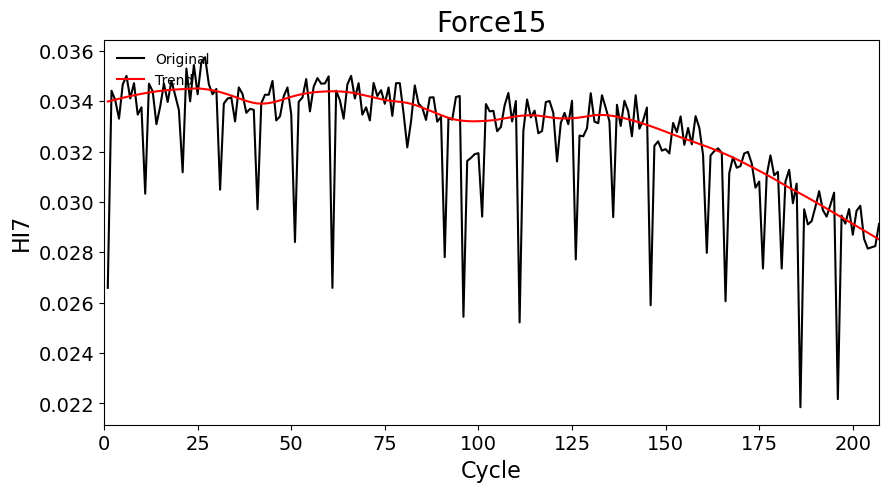

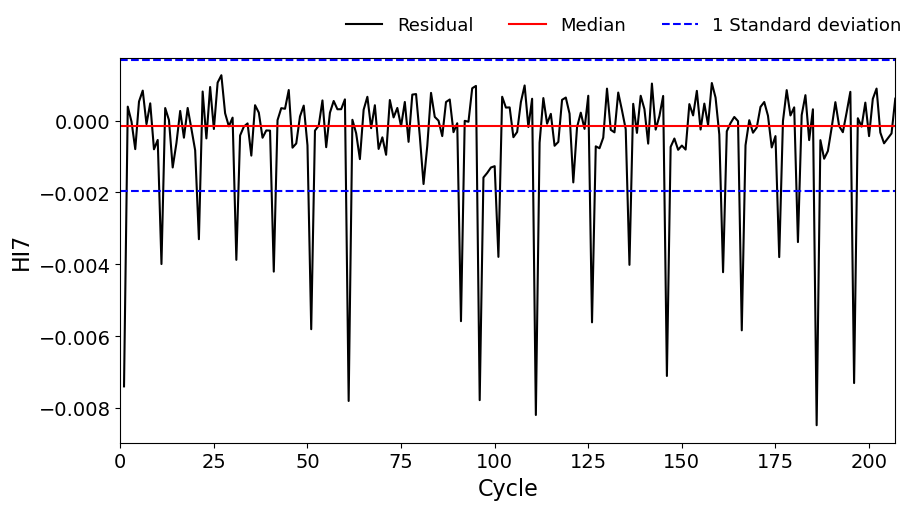

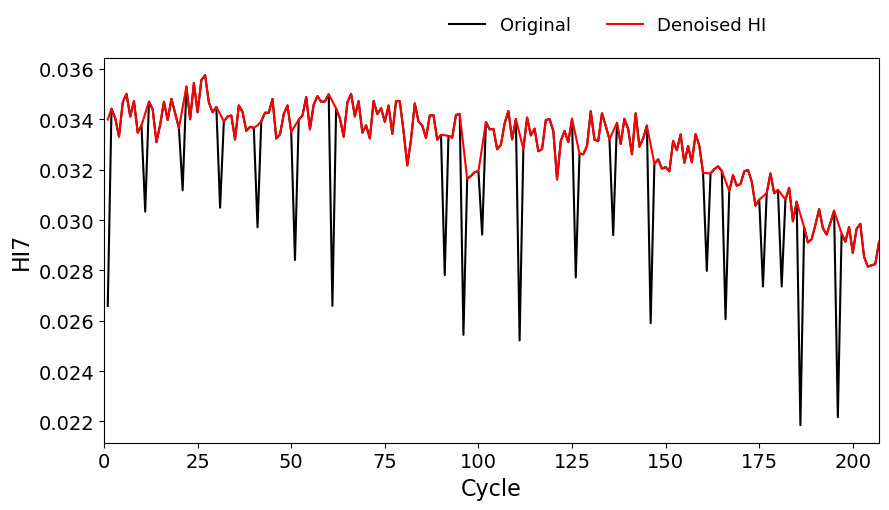

In [35]:
x= data['Cycle']
y= data.iloc[0:,8]

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)
print(y.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data.iloc[0:,8]
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI7",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI7",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-1)*std<=t<=median+1*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CVIS'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            target=np.median([denoised_1,denoised_2])
            abs_diff=np.abs(minus-target)
            min_index=np.argmin(abs_diff)
            
            denoised_val=y_trend[cycle-1]+minus[min_index] # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_CVIS=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_CVIS,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI7",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(207,)
(207,)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.478
Model:                            WLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     93.45
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           1.56e-29
Time:                        20:58:28   Log-Likelihood:                   -inf
No. Observations:                 207   AIC:                               inf
Df Residuals:                     204   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0040      0.002      

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


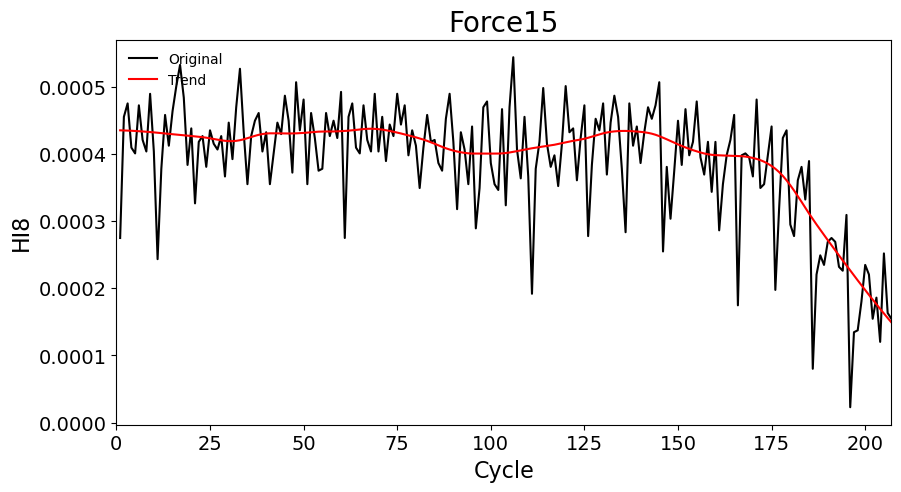

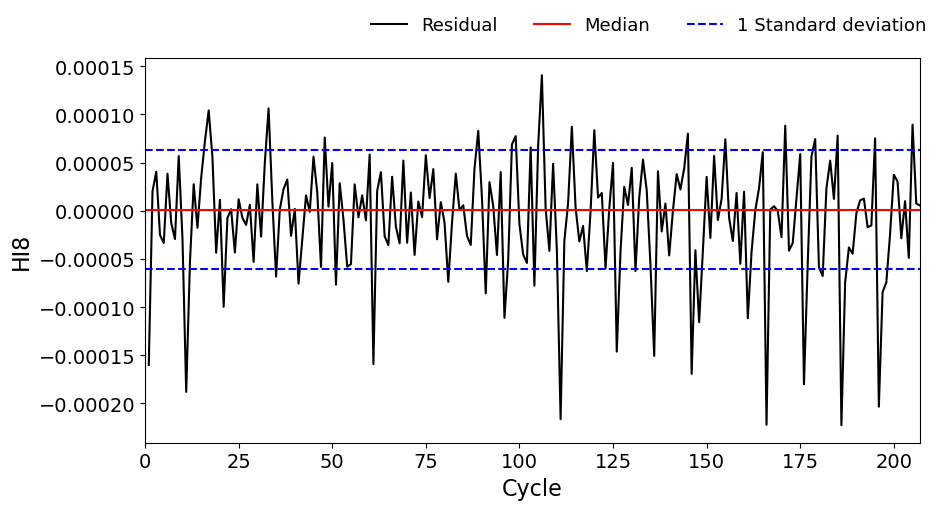

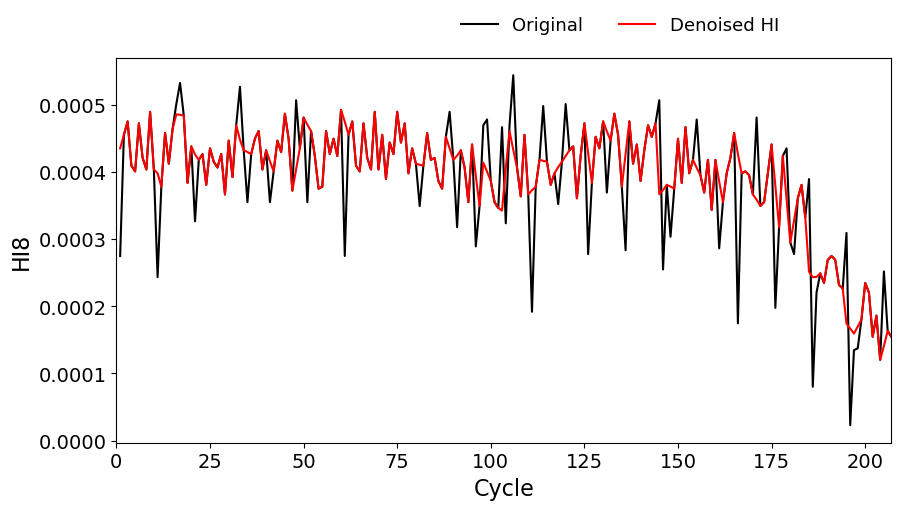

In [36]:
x= data['Cycle']
y= data.iloc[0:,9]

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)
print(y.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data.iloc[0:,9]
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI8",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI8",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-1)*std<=t<=median+1*std:
        denoised_val=data.loc[data['Cycle']==cycle,'CVES'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            target=np.median([denoised_1,denoised_2])
            abs_diff=np.abs(minus-target)
            min_index=np.argmin(abs_diff)
            
            denoised_val=y_trend[cycle-1]+minus[min_index] # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_CVES=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_CVES,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI8",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


(207,)
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.892
Model:                            WLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     844.1
Date:                Sun, 24 Mar 2024   Prob (F-statistic):           2.15e-99
Time:                        20:58:29   Log-Likelihood:                   -inf
No. Observations:                 207   AIC:                               inf
Df Residuals:                     204   BIC:                               inf
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7097      0.045     60.207  

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\statsmodels\regression\linear_model.py:792: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


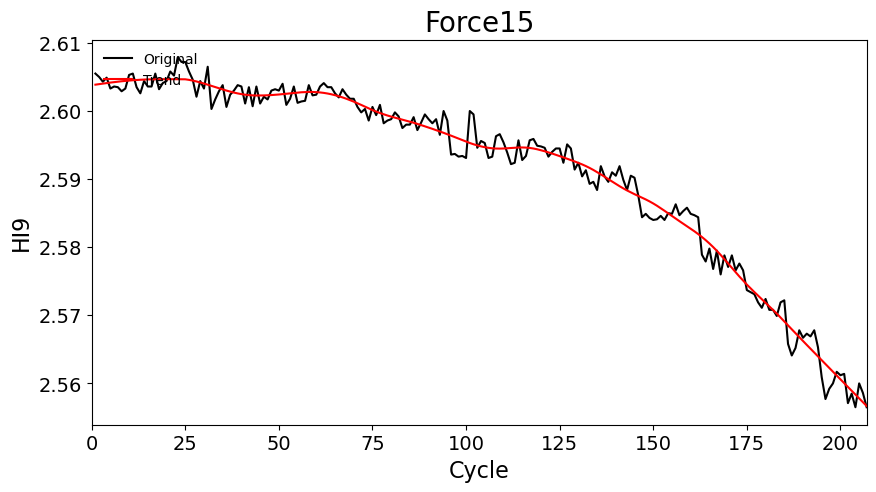

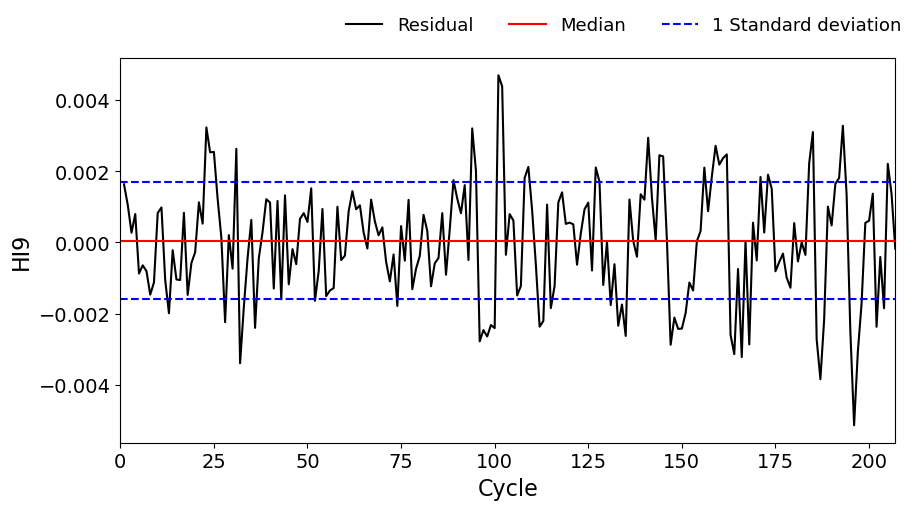

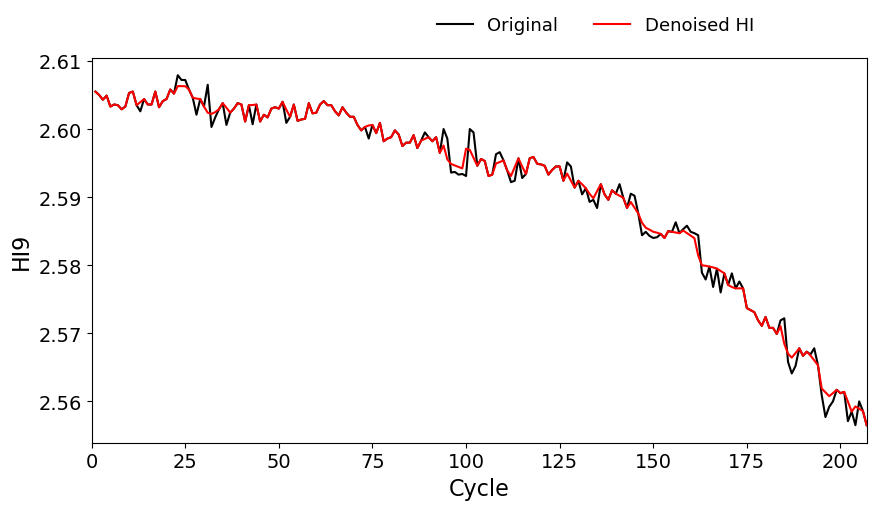

In [37]:
x= data['Cycle']
y= data['DIV']

import statsmodels.api as sm
# RLWR
r=50
count=1

x_s=np.array(x)
y=np.array(y)
fitted_value=[]
print(x_s.shape)



# step1
for t in x_s:
    h=get_n_th_distance(t,x_s,r)
    weights=tricube((t-x_s)/h)
    idx=np.where(weights>0)[0]
    X = np.column_stack((x_s, x_s**2))
    X_const=sm.add_constant(X)
    fit=sm.WLS(y,X_const,weights=weights).fit()
    fitted_val=fit.params[0]+fit.params[1]*t+fit.params[2]*t**2
    fitted_value.append(fitted_val)
    
fitted_value=np.array(fitted_value) 


print(fit.summary())
print(fit.params)
print(fitted_value.shape)

t=5
count=1
while count <= t:
    count +=1
    abs_residual=abs(y-fitted_value)
    s=np.median(abs_residual)
    new_fitted_value=[]
    for x in x_s:
        h=get_n_th_distance(x,x_s,r)
        delta=bisquare((y-fitted_value)/(6*s))
        weights=delta*tricube((x-x_s)/h)
        idx=np.where(weights>0)[0]
        X = np.column_stack((x_s, x_s**2))
        X_const=sm.add_constant(X)
        fit=sm.WLS(y,X_const,weights).fit()
        fitted_val=fit.params[0]+fit.params[1]*x+fit.params[2]*x**2
        new_fitted_value.append(fitted_val)
        
    new_fitted_value=np.array(new_fitted_value)
    fitted_value=new_fitted_value
    
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

x= data['Cycle']
y_origin= data['DIV']
y_trend= fitted_value
y_max=y.max()
y_min=y.min()
y_dat=(y-y_min)/(y_max-y_min)
plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_trend,'r-',label='Trend')
plt.legend(loc='upper left',frameon=False)
plt.title("Force15",fontsize=20)
plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI9",fontsize=16)
plt.xlim([0,len(x)])
plt.show()



y_res=y_origin-y_trend

median=np.median(y_res)
std=np.std(y_res)


plt.figure(figsize=(10,5))
plt.plot(x, y_res,'k-', label='Residual')

plt.legend(loc='upper left',frameon=False)

plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI9",fontsize=16)
plt.xlim([0,len(x)])
plt.axhline(median, color='red', linestyle='-', label='Median')
plt.axhline(median+1*std,color='blue',linestyle='--',label='1 Standard deviation')
plt.axhline(median-1*std,color='blue',linestyle='--')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()

median=np.median(y_res)
std=np.std(y_res)

denoised=[]
cycle=1
def closer_number(target, cycle):
    # target에 더 가까운 수 찾기
    return cycle-1 if abs(target - y_res[cycle-2]) < abs(target - y_res[cycle]) else cycle+1

for t in y_res:
    
    if median+(-1)*std<=t<=median+1*std:
        denoised_val=data.loc[data['Cycle']==cycle,'DIV'].iloc[0]
    else :
        if cycle==1:
            denoised_val=y_trend[0]
        elif cycle==len(y_res):
            denoised_val=denoised[-1]
        else :
            denoised_1=y_res[cycle]
            
            minus=denoised-y_trend[:len(denoised)]
            denoised_2=minus[-1]
            target=np.median([denoised_1,denoised_2])
            abs_diff=np.abs(minus-target)
            min_index=np.argmin(abs_diff)
            
            denoised_val=y_trend[cycle-1]+minus[min_index] # 잔차+ 트렌드= 오리지널
    denoised.append(denoised_val)
    cycle +=1

y_denoised_DIV=np.array(denoised)


plt.figure(figsize=(10,5))
plt.plot(x, y_origin,'k-', label='Original')
plt.plot(x,y_denoised_DIV,'r-',label='Denoised HI')



plt.xlabel("Cycle",fontsize=16)
plt.ylabel("HI9",fontsize=16)
plt.xlim([0,len(x)])


plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=13)
plt.show()


In [60]:
df = pd.DataFrame({'HI1': y_denoised_max, 'HI2': y_denoised_min, 'HI3': y_denoised_maxmin,
                  'HI4': y_denoised_civ, 'HI5': y_denoised_CCVIS, 'HI6': y_denoised_CCVES,
                  'HI7': y_denoised_CVIS, 'HI8': y_denoised_CVES, 'HI9': y_denoised_DIV})

print(df)

           HI1        HI2        HI3       HI4        HI5       HI6       HI7  \
0    21.100000   4.100000  16.898929  2.679371  16.526000  1.938000  0.033991   
1    21.100000   4.100000  16.870938  2.680319  16.502000  1.934680  0.034420   
2    21.200000   4.300000  16.843112  2.681246  16.396000  1.931527  0.034040   
3    21.400000   4.600000  16.815445  2.682152  16.340000  1.928537  0.033310   
4    21.700000   4.800000  16.787932  2.683039  16.310000  1.925702  0.034670   
..         ...        ...        ...       ...        ...       ...       ...   
202  37.501757  23.535579  13.927524  2.879206  12.430000  1.757163  0.028540   
203  37.500000  23.574060  13.934199  2.881596  12.404000  1.759622  0.028150   
204  37.600000  23.636698  13.941439  2.883990  12.364000  1.762000  0.028200   
205  37.750584  23.700000  13.949221  2.886389  12.345903  1.744000  0.028250   
206  37.900000  23.700000  13.957519  2.888789  12.324000  1.764000  0.029130   

          HI8       HI9  
0

In [61]:
from sklearn.preprocessing import MinMaxScaler

In [62]:
# 예제 데이터프레임 생성 (558, 9) 형태라고 가정
# data = pd.DataFrame(...)

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler()

# 데이터 정규화 수행
data_normalized = scaler.fit_transform(df)

# 정규화된 데이터를 다시 DataFrame으로 변환
data_norm_denoised = pd.DataFrame(data_normalized, columns=df.columns)

# 정규화된 데이터 확인
data_norm_denoised.head()

,HI1,HI2,HI3,HI4,HI5,HI6,HI7,HI8,HI9
0,0.000000,0.000000,1.000000,0.000000,1.000000,0.907563,0.768608,0.846215,0.983900
1,0.000000,0.000000,0.990686,0.004527,0.994288,0.893613,0.825000,0.900185,0.973861
2,0.005952,0.010181,0.981427,0.008953,0.969062,0.880366,0.775000,0.953957,0.959805
3,0.017857,0.025453,0.972221,0.013282,0.955735,0.867801,0.678947,0.777011,0.971853
4,0.035714,0.035635,0.963066,0.017518,0.948596,0.855891,0.857895,0.753822,0.939725


In [63]:
data=pd.read_csv("./data_paper/Swelling35C.csv")

print(data.shape)

# data가 pandas DataFrame이고, shape이 (558, 13)이라고 가정합니다.

# 'cycle', 'soh', 'DVSOC50' 열을 제외하고 나머지 데이터만 유지
# 여기서 'cycle'이 2개 있다고 하셨으니, 구체적인 열 이름이 필요할 수 있습니다.
# 예를 들어, 'cycle1', 'cycle2' 같이 구분이 되어 있다면 아래와 같이 작성합니다.
data_reduced = data.drop(['Unnamed: 0', 'Cycle', 'SOH', 'DVSOC50'], axis=1)

# 결과 확인
print(data_reduced.shape)  # 이제 (558, 9)가 되어야 합니다.
data_reduced.head()

(207, 13)
(207, 9)


,max.,min.,max.-min.,CIV,CCVIS,CCVES,CVIS,CVES,DIV
0,20.5,3.7,16.8,2.6737,16.526,1.938,0.02659,0.000275,2.6055
1,21.1,4.1,17.0,2.6749,16.502,1.978,0.03442,0.000455,2.6050
2,21.2,4.3,16.9,2.6802,16.396,1.982,0.03404,0.000475,2.6043
3,21.4,4.6,16.8,2.6830,16.340,1.978,0.03331,0.000409,2.6049
4,21.7,4.8,16.9,2.6845,16.310,1.892,0.03467,0.000400,2.6033


In [64]:
# 예제 데이터프레임 생성 (558, 9) 형태라고 가정
# data = pd.DataFrame(...)

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler()

# 데이터 정규화 수행
data_normalized = scaler.fit_transform(data_reduced)

# 정규화된 데이터를 다시 DataFrame으로 변환
data_normalized = pd.DataFrame(data_normalized, columns=data_reduced.columns)

# 정규화된 데이터 확인
data_normalized.head()

,max.,min.,max.-min.,CIV,CCVIS,CCVES,CVIS,CVES,DIV
0,0.000000,0.000000,0.939394,0.000000,1.000000,0.837037,0.341007,0.483534,0.953307
1,0.034483,0.019608,1.000000,0.005170,0.994830,0.985185,0.904317,0.829686,0.943580
2,0.040230,0.029412,0.969697,0.028005,0.971995,1.000000,0.876978,0.868094,0.929961
3,0.051724,0.044118,0.939394,0.040069,0.959931,0.985185,0.824460,0.741706,0.941634
4,0.068966,0.053922,0.969697,0.046532,0.953468,0.666667,0.922302,0.725143,0.910506


In [65]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import os
import random


def build_autoencoder(input_dim, encoding_dim):
    # 입력 레이어
    input_layer = Input(shape=(input_dim,))
    
    # 인코더 레이어: 입력을 encoding_dim 차원으로 압축, He 초기화 사용
    encoded = Dense(encoding_dim[0], activation='elu')(input_layer)
    encoded = Dense(encoding_dim[1], activation='elu')(encoded)
    
    # 디코더 레이어: encoding_dim 차원을 다시 입력 차원으로 복원, He 초기화 사용
    decoded = Dense(encoding_dim[0], activation='elu')(encoded)
    decoded = Dense(input_dim, activation='elu')(decoded)
    
    # 오토인코더 모델 생성
    autoencoder = Model(input_layer, decoded)
    
    # 인코더 모델 생성
    encoder = Model(input_layer, encoded)
    
    # 디코더 모델 생성
    encoded_input = Input(shape=(encoding_dim[1],))
    decoder_layer1 = autoencoder.layers[-2](encoded_input)
    decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
    decoder = Model(encoded_input, decoder_layer2)
    
    return autoencoder, encoder, decoder

# 모델 구축
input_dim = 9  # 입력 차원
encoding_dim = [6, 4]  # 인코더의 두 레이어에서의 차원
autoencoder, encoder, decoder = build_autoencoder(input_dim, encoding_dim)

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 30        
_________________________________________________________________
dense_11 (Dense)             (None, 9)                 63        
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [66]:
# data.shape는 (558, 9)입니다.

# 첫 277개 행을 훈련 데이터로 사용
X_train = data_norm_denoised
X_test=data_norm_denoised

# 모델 훈련
autoencoder.fit(X_train, X_train, epochs=400, batch_size=32,validation_data=(X_train,X_train))

# 테스트 데이터에 대한 재구성
reconstructed = autoencoder.predict(X_test)




Train on 207 samples, validate on 207 samples
Epoch 1/400
207/207 [==============================] - 0s 1ms/sample - loss: 0.5764 - val_loss: 0.5527
Epoch 2/400
207/207 [==============================] - 0s 159us/sample - loss: 0.5387 - val_loss: 0.5173
Epoch 3/400
207/207 [==============================] - 0s 155us/sample - loss: 0.5044 - val_loss: 0.4849
Epoch 4/400
207/207 [==============================] - 0s 116us/sample - loss: 0.4729 - val_loss: 0.4547
Epoch 5/400
207/207 [==============================] - 0s 188us/sample - loss: 0.4432 - val_loss: 0.4262
Epoch 6/400
207/207 [==============================] - 0s 150us/sample - loss: 0.4157 - val_loss: 0.3988
Epoch 7/400
207/207 [==============================] - 0s 151us/sample - loss: 0.3884 - val_loss: 0.3726
Epoch 8/400
207/207 [==============================] - 0s 126us/sample - loss: 0.3626 - val_loss: 0.3469
Epoch 9/400
207/207 [==============================] - 0s 106us/sample - loss: 0.3370 - val_loss: 0.3219
Epoch 10/40

207/207 [==============================] - 0s 97us/sample - loss: 0.0066 - val_loss: 0.0065
Epoch 79/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0065 - val_loss: 0.0064
Epoch 80/400
207/207 [==============================] - 0s 92us/sample - loss: 0.0064 - val_loss: 0.0063
Epoch 81/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0063 - val_loss: 0.0062
Epoch 82/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0062 - val_loss: 0.0062
Epoch 83/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0061 - val_loss: 0.0061
Epoch 84/400
207/207 [==============================] - 0s 87us/sample - loss: 0.0061 - val_loss: 0.0060
Epoch 85/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0060 - val_loss: 0.0060
Epoch 86/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0059 - val_loss: 0.0059
Epoch 87/400
207/207 [==============================] - 0s 135us/

207/207 [==============================] - 0s 97us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 156/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0045 - val_loss: 0.0044
Epoch 157/400
207/207 [==============================] - 0s 92us/sample - loss: 0.0044 - val_loss: 0.0044
Epoch 158/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0044 - val_loss: 0.0044
Epoch 159/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0044 - val_loss: 0.0044
Epoch 160/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0044 - val_loss: 0.0044
Epoch 161/400
207/207 [==============================] - 0s 92us/sample - loss: 0.0044 - val_loss: 0.0044
Epoch 162/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0044 - val_loss: 0.0044
Epoch 163/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0044 - val_loss: 0.0044
Epoch 164/400
207/207 [==============================] -

207/207 [==============================] - 0s 97us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 233/400
207/207 [==============================] - 0s 111us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 234/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 235/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 236/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 237/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 238/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 239/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 240/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 241/400
207/207 [==============================] - 

Epoch 309/400
207/207 [==============================] - 0s 111us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 310/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 311/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 312/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 313/400
207/207 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 314/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 315/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 316/400
207/207 [==============================] - 0s 106us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 317/400
207/207 [==============================] - 0s 92us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 318/400
207/207 [================

Epoch 386/400
207/207 [==============================] - 0s 106us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 387/400
207/207 [==============================] - 0s 92us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 388/400
207/207 [==============================] - 0s 97us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 389/400
207/207 [==============================] - 0s 106us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 390/400
207/207 [==============================] - 0s 111us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 391/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 392/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 393/400
207/207 [==============================] - 0s 101us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 394/400
207/207 [==============================] - 0s 92us/sample - loss: 0.0023 - val_loss: 0.0023
Epoch 395/400
207/207 [=================

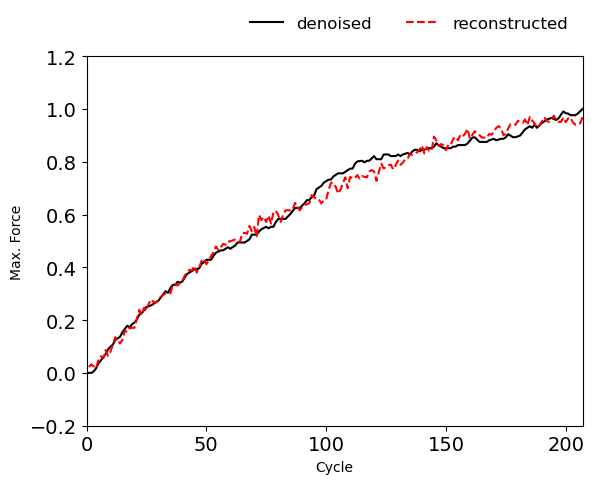

In [67]:

y= reconstructed[:,0]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI1']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("Max. Force")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

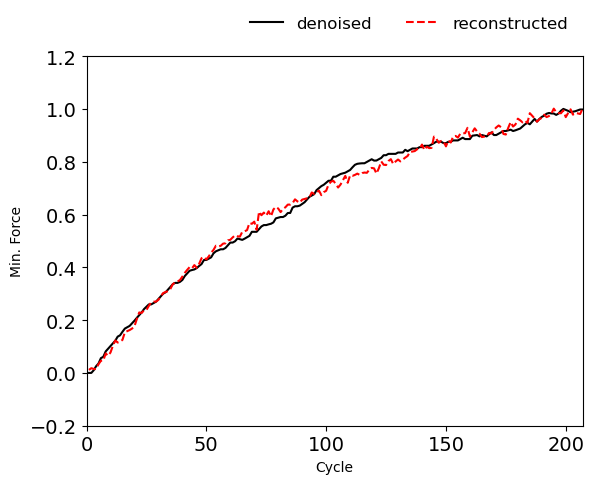

In [68]:
y= reconstructed[:,1]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI2']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("Min. Force")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

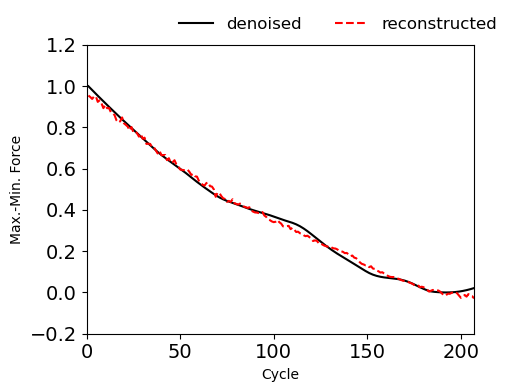

In [69]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,2]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI3']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("Max.-Min. Force")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

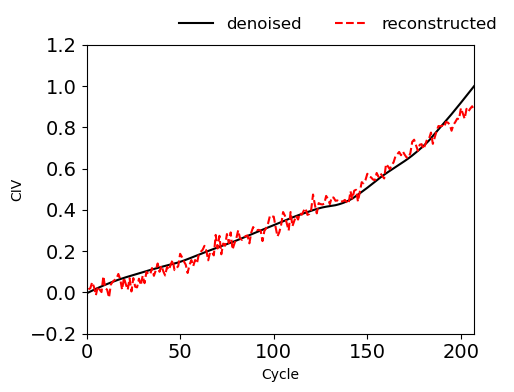

In [70]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,3]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI4']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("CIV")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

<Figure size 500x375 with 0 Axes>

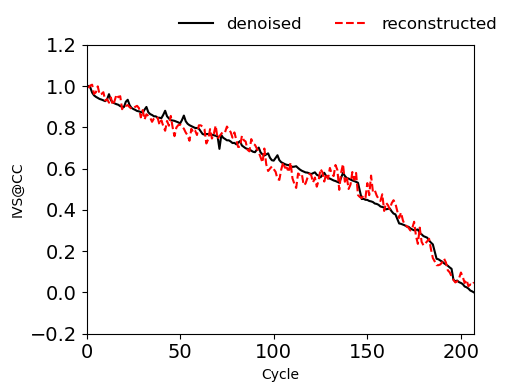

In [71]:
plt.figure(figsize=(5,3.75))
plt.figure(figsize=(5,3.75))
y= reconstructed[:,4]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI5']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("IVS@CC")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

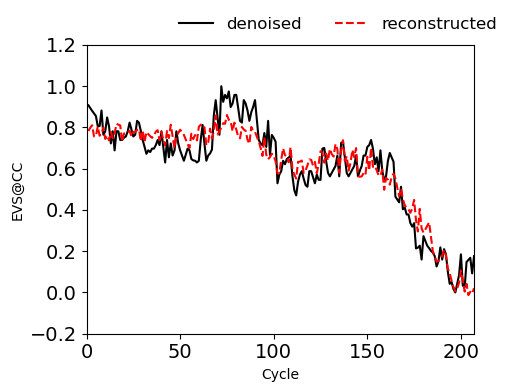

In [72]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,5]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI6']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("EVS@CC")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

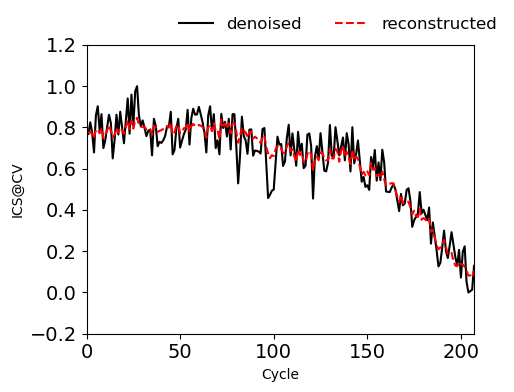

In [73]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,6]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI7']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("ICS@CV")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

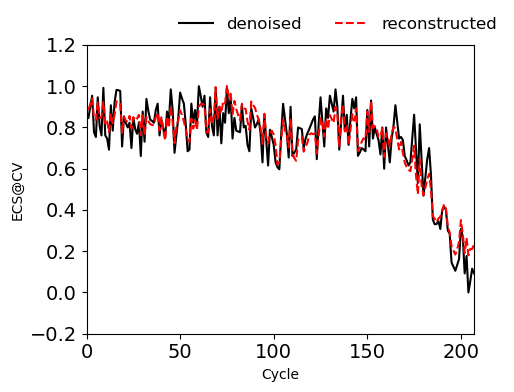

In [74]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,7]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI8']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("ECS@CV")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

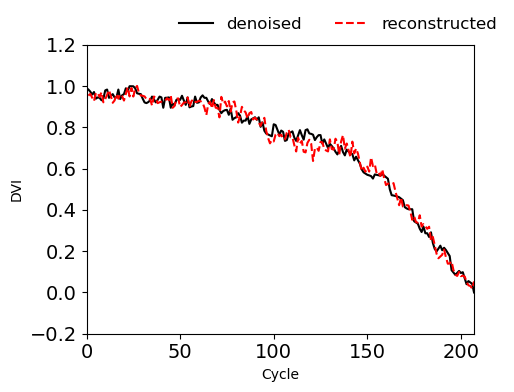

In [75]:
plt.figure(figsize=(5,3.75))
y= reconstructed[:,8]
x= np.arange(1, len(y) + 1)
y_ori=data_norm_denoised['HI9']
plt.plot(x,y_ori,'k-',label='denoised')
plt.plot(x,y,'r--',label='reconstructed')

plt.xlabel("Cycle")
plt.ylabel("DVI")
plt.xlim([0,len(x)])
plt.ylim(-0.2,1.2)
plt.axvline(277,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='upper center', bbox_to_anchor=(0.65,1.15),ncol=3, frameon=False,fontsize=12)
plt.show()

In [76]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

x=reconstructed
y=data['SOH']*100

x_train=x[:130,:]
y_train=y[:130]

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))

# GPR 모델 생성 및 학습
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
gp.fit(x_train, y_train)

# SOH 추정
y_pred, sigma = gp.predict(x, return_std=True)

from sklearn.metrics import mean_squared_error
from math import sqrt

# 실제 SOH 값(y)과 예측된 SOH 값(y_pred)을 사용하여 RMSE 계산
rmse = sqrt(mean_squared_error(y, y_pred))

print("RMSE:", rmse)

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RMSE: 0.13897325981677508


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


In [77]:
x=reconstructed[:,:3]
y=data['SOH']*100

x_train=x[:130,:]
y_train=y[:130]

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))

# GPR 모델 생성 및 학습
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
gp.fit(x_train, y_train)

# SOH 추정
y_mechanical, sigma = gp.predict(x, return_std=True)

from sklearn.metrics import mean_squared_error
from math import sqrt

# 실제 SOH 값(y)과 예측된 SOH 값(y_pred)을 사용하여 RMSE 계산
rmse = sqrt(mean_squared_error(y, y_mechanical))

print("RMSE:", rmse)

RMSE: 1.0278149232894698


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


In [78]:
x=reconstructed[:,3:]
y=data['SOH']*100

x_train=x[:130,:]
y_train=y[:130]

kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))

# GPR 모델 생성 및 학습
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=False)
gp.fit(x_train, y_train)

# SOH 추정
y_Impedance, sigma = gp.predict(x, return_std=True)

from sklearn.metrics import mean_squared_error
from math import sqrt

# 실제 SOH 값(y)과 예측된 SOH 값(y_pred)을 사용하여 RMSE 계산
rmse = sqrt(mean_squared_error(y, y_Impedance))

print("RMSE:", rmse)

C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


RMSE: 1.8605579064164919


C:\Users\tlsdu\anaconda3\envs\tfgpu\lib\site-packages\sklearn\gaussian_process\kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


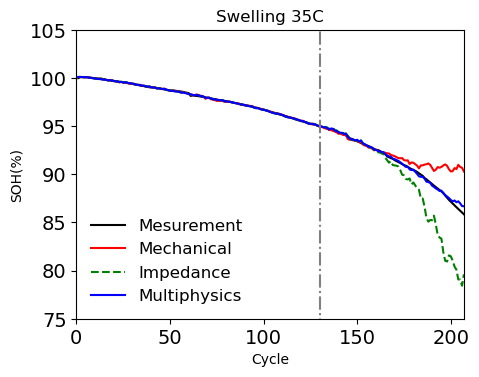

In [79]:
plt.figure(figsize=(5,3.75))
y_2= y_mechanical
y_4=y_pred
y_3=y_Impedance
x= np.arange(1, len(y) + 1)
y_soh=data['SOH']*100
plt.plot(x,y_soh,'k-',label='Mesurement')
plt.plot(x,y_2,'r-',label='Mechanical')
plt.plot(x,y_3,'g--',label='Impedance')
plt.plot(x,y_4,'b-',label='Multiphysics')

plt.title("Swelling 35C")
plt.xlabel("Cycle")
plt.ylabel("SOH(%)")
plt.xlim([0,len(x)])
plt.ylim(75,105)
plt.axvline(130,-0.2,1.2,color='gray',linestyle='dashdot')
plt.legend(loc='lower left',frameon=False,fontsize=12)
plt.show()

